# COVID 19 Risk Inequatliy in London

In [ ]:
import geopandas as gpd
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
# from pysal.viz import mapclassify
import mapclassify
import seaborn as sns
import contextily as ctx

## Load data:

In [ ]:
path = Path('data/')

In [ ]:
lon = gpd.read_file(path/'statistical-gis-boundaries-london/ESRI/MSOA_2004_London_High_Resolution.shp')

In [ ]:
lon.head()

,MSOA_CODE,MSOA_NAME,LA_CODE,LA_NAME,GEOEAST,GEONORTH,POPEAST,POPNORTH,AREA_KM2,geometry
0,E02000001,City of London 001,00AA,City of London,532464,181220,532458,181630,3.15147,"POLYGON ((532946.061 181894.832, 532946.070 18..."
1,E02000002,Barking and Dagenham 001,00AB,Barking and Dagenham,548313,189878,547997,189392,2.16157,"POLYGON ((548877.688 191097.328, 548877.680 19..."
2,E02000003,Barking and Dagenham 002,00AB,Barking and Dagenham,548456,188400,548377,188094,2.14152,"POLYGON ((548954.499 189063.200, 548889.701 18..."
3,E02000004,Barking and Dagenham 003,00AB,Barking and Dagenham,551010,186308,550921,186823,2.49295,"POLYGON ((551550.003 187364.637, 551549.995 18..."
4,E02000005,Barking and Dagenham 004,00AB,Barking and Dagenham,548666,186903,548707,186820,1.18795,"POLYGON ((549026.800 186159.802, 549014.498 18..."


In [ ]:
# fig, ax = plt.subplots(figsize=(10,10))
# lon.plot('POPDEN',legend = False, ax = ax)
# ax.set_axis_off()

### Load COVID data from covid.gov

In [ ]:
c19_pos = pd.read_csv(path/'london_c19.csv')

In [ ]:
c19_pos.head()

,regionCode,regionName,UtlaCode,UtlaName,LtlaCode,LtlaName,areaType,areaCode,areaName,date,newCasesBySpecimenDateRollingSum
0,E12000007,London,E09000012,Hackney and City of London,E09000012,Hackney and City of London,msoa,E02000001,City of London,2021-01-23,17.0
1,E12000007,London,E09000012,Hackney and City of London,E09000012,Hackney and City of London,msoa,E02000001,City of London,2021-01-16,39.0
2,E12000007,London,E09000012,Hackney and City of London,E09000012,Hackney and City of London,msoa,E02000001,City of London,2021-01-09,29.0
3,E12000007,London,E09000012,Hackney and City of London,E09000012,Hackney and City of London,msoa,E02000001,City of London,2021-01-02,52.0
4,E12000007,London,E09000012,Hackney and City of London,E09000012,Hackney and City of London,msoa,E02000001,City of London,2020-12-26,46.0


In [ ]:
c19_pos.set_index('date', inplace = True)

Renaming area code to match the shp file

In [ ]:
c19_pos.rename(columns={'areaCode':'MSOA_CODE'},inplace= True)

To create the cumlative casenumber

In [ ]:
c19_sum = c19_pos.groupby(['MSOA_CODE']).sum()

Then merge on shp file msoa

In [ ]:
lon_c19 = lon.merge(c19_sum, on='MSOA_CODE')

### Set CRS

https://epsg.io/27700

In [ ]:
crs = "EPSG:27700" # OSGB 1936 / British National Grid

In [ ]:
#crs = "EPSG:4326" #WGS84 

# Plot the number of cases in London

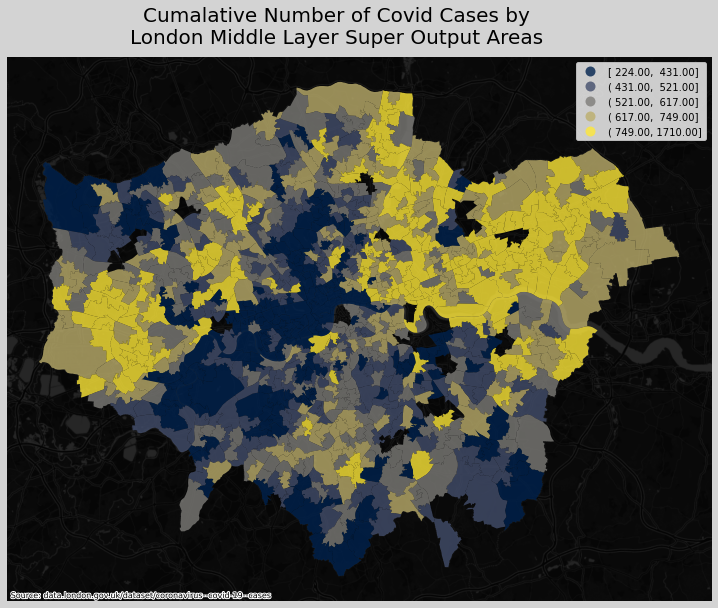

In [ ]:
fig, (ax) = plt.subplots(1,1,figsize=(25,10))
# maj_roads.plot(ax = ax,
#            linewidth=2, 
#            alpha = 0.2, 
#            color='white')
lon_c19.to_crs(crs).plot('newCasesBySpecimenDateRollingSum',
             scheme = 'quantiles',
             legend = True,cmap = 'cividis',
             ax = ax, alpha =0.8)

# lon_c19.to_crs(epsg=22770).plot(ax=ax, color= 'white',alpha=0.6)

ctx.add_basemap(ax,
                source=ctx.providers.CartoDB.DarkMatterNoLabels, 
                crs=crs,
                attribution= 'Source: data.london.gov.uk/dataset/coronavirus--covid-19--cases')

fig.suptitle('Cumalative Number of Covid Cases by\nLondon Middle Layer Super Output Areas', size=20, y=0.95)
fig.set_facecolor('lightgray')

ax.set_axis_off()
plt.show()
fig.savefig('Cumalative_London_C19.png',dpi=350,bbox_inches = "tight")


## Disbution of quartiles

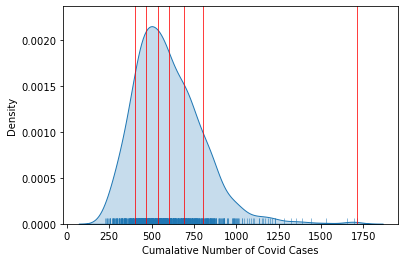

In [ ]:
classi = mapclassify.Quantiles(lon_c19["newCasesBySpecimenDateRollingSum"], k=7)
classi

# Set up the figure
fig, ax = plt.subplots(1)
# Plot the kernel density estimation (KDE)
sns.kdeplot(lon_c19["newCasesBySpecimenDateRollingSum"], shade=True, ax=ax)
# Add a blue tick for every value at the bottom of the plot (rugs)
sns.rugplot(lon_c19["newCasesBySpecimenDateRollingSum"], alpha=0.5, ax=ax)



# Loop over each break point and plot a vertical red line
for cut in classi.bins:
    ax.axvline(cut, color='red', linewidth=0.75)
    
    
ax.set_xlabel('Cumalative Number of Covid Cases')

# Display image
plt.show()


# Corrolation with space?

In [ ]:
from splot.esda import moran_scatterplot, lisa_cluster, plot_local_autocorrelation
import esda
from pysal.lib import weights

# Create an aggency plot

In [ ]:
w = weights.Queen.from_dataframe(lon_c19, idVariable= 'MSOA_CODE')

In [ ]:
lisa = esda.Moran_Local(lon_c19['newCasesBySpecimenDateRollingSum'], w)

In [ ]:
lon_c19['significant'] = lisa.p_sim < 0.05

# Store the quadrant they belong to
lon_c19['quadrant'] = lisa.q

In [ ]:
import matplotlib.patches as mpatches

## LISA
*with custom colors*

## Plot LISA

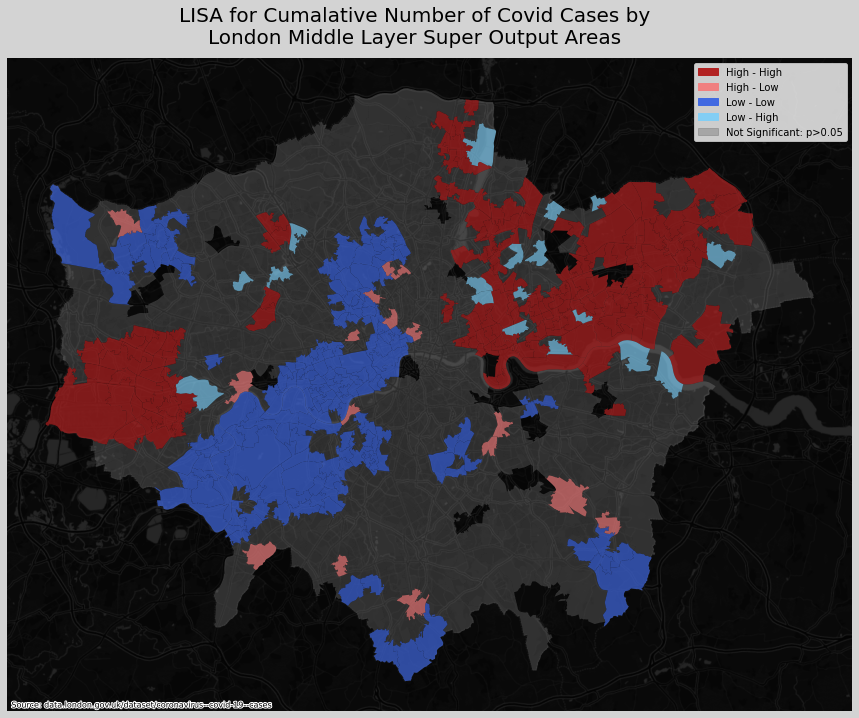

In [ ]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(17, 12))

# Plot insignificant clusters
ns = lon_c19.loc[lon_c19['significant']==False, 'geometry']
ns.to_crs(crs).plot(ax=ax, color='lightgray', alpha =0.2)

# Plot HH clusters
hh = lon_c19.loc[(lon_c19['quadrant']==1) & (lon_c19['significant']==True), 'geometry']
hh.to_crs(crs).plot(ax=ax, color='firebrick', alpha = 0.7)
# Plot LL clusters
ll = lon_c19.loc[(lon_c19['quadrant']==3) & (lon_c19['significant']==True), 'geometry']
ll.to_crs(crs).plot(ax=ax, color='royalblue', alpha = 0.7)
# Plot LH clusters
lh = lon_c19.loc[(lon_c19['quadrant']==2) & (lon_c19['significant']==True), 'geometry']
lh.to_crs(crs).plot(ax=ax, color='#83cef4', alpha = 0.7)
# Plot HL clusters
hl = lon_c19.loc[(lon_c19['quadrant']==4) & (lon_c19['significant']==True), 'geometry']
hl.to_crs(crs).plot(ax=ax, color='lightcoral', alpha = 0.7)

# Add basemap
ctx.add_basemap(ax,
               crs=crs,
               source=ctx.providers.CartoDB.DarkMatterNoLabels,attribution= 'Source: data.london.gov.uk/dataset/coronavirus--covid-19--cases'
              )

#Legend
hh_lab = mpatches.Patch(color='firebrick', label='High - High')
hl_lab = mpatches.Patch(color='lightcoral', label='High - Low')

ll_lab = mpatches.Patch(color='royalblue', label='Low - Low')
lh_lab = mpatches.Patch(color='#83cef4', label='Low - High')

ns_lab= mpatches.Patch(color='gray', alpha = 0.5, label='Not Significant: p>0.05')

plt.legend(handles=[hh_lab,hl_lab,ll_lab,lh_lab,ns_lab])


# plt.rotate(-65, origin=(0,0))
# Style and draw
f.suptitle('LISA for Cumalative Number of Covid Cases by\nLondon Middle Layer Super Output Areas', size=20, y=0.94)
f.set_facecolor('lightgray')

ax.set_axis_off()
plt.show()
f.savefig('LISA_London_C19.png',dpi=350,bbox_inches = "tight")

In [ ]:
#std lisa colors

# fig, ax = plt.subplots(1, figsize=(9, 9))

# lisa_cluster(lisa, 
#              lon_c19.to_crs(crs), 
#              ax = ax)

# # Add basemap
# ctx.add_basemap(ax,
#                crs=crs,
#                source=ctx.providers.CartoDB.DarkMatterNoLabels,attribution= 'LMS'
#               )

# # Remove axis
# ax.set_axis_off()
# # Display clean
# plt.show()

There is statisitcaly sugnficant clusltering cumlative covid cases

Of Low Low cases in the west/south

and High High cases in the east 

# K means 

In [ ]:
from sklearn import cluster

In [ ]:
kmeans5 = cluster.KMeans(n_clusters=4, random_state=12345)

In [ ]:
filt = ['newCasesBySpecimenDateRollingSum']

In [ ]:
# Run the clustering algorithm
k5cls = kmeans5.fit(lon_c19[filt])

In [ ]:
lon_c19['k5cls'] = k5cls.labels_

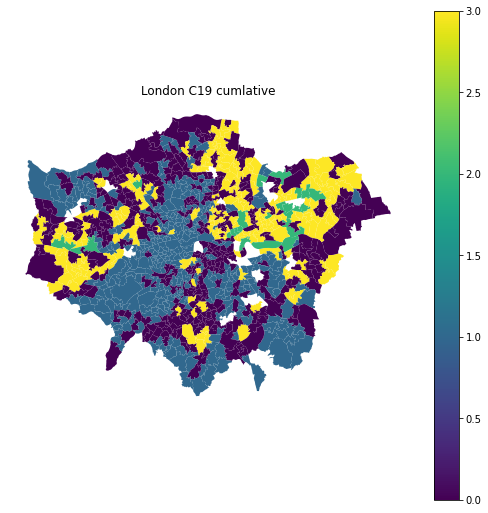

In [ ]:
# Setup figure and ax
fig, ax = plt.subplots(1, figsize=(9, 9))
# Plot unique values choropleth including a legend and with no boundary lines
lon_c19.plot(column='k5cls', categorical=False, legend=True, linewidth=0, ax=ax)
# Remove axis
ax.set_axis_off()
# Add title
plt.title('London C19 cumlative')
# Display the map
plt.show()

In [ ]:
k5sizes = lon_c19.groupby('k5cls').size()
k5sizes

k5cls
0    358
1    365
2     24
3    204
dtype: int64

# Aglomartive clustering

In [ ]:
from pysal.lib import weights

In [ ]:
w = weights.Queen.from_dataframe(lon_c19)

In [ ]:
lon_cls = cluster.AgglomerativeClustering(n_clusters=5, connectivity=w.sparse)

In [ ]:
lon_cls = lon_cls.fit(lon_c19[filt])

In [ ]:
lon_c19['lon_cls'] = lon_cls.labels_

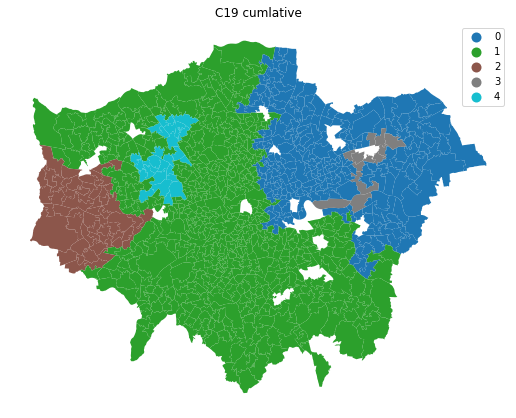

In [ ]:
# Setup figure and ax
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot unique values choropleth including a legend and with no boundary lines
lon_c19.plot(column='lon_cls', categorical=True, legend=True, linewidth=0, ax=ax)
# Remove axis
ax.set_axis_off()
# Add title
plt.title('C19 cumlative')
# Display the map
plt.show()

In [ ]:
def dissolve(gs):
    '''
    Take a series of polygons and dissolve them into a single one
    
    Arguments
    ---------
    gs        : GeoSeries
                Sequence of polygons to be dissolved
    Returns
    -------
    dissolved : Polygon
                Single polygon containing all the polygons in `gs`
    '''
    return gs.unary_union

In [ ]:
lon_boroughs = gpd.GeoSeries(lon_c19.groupby(lon_c19['lon_cls']).apply(dissolve),crs=lon_c19.crs)

Text(0.5, 1.0, 'AirBnb-based boroughs for Inner London')

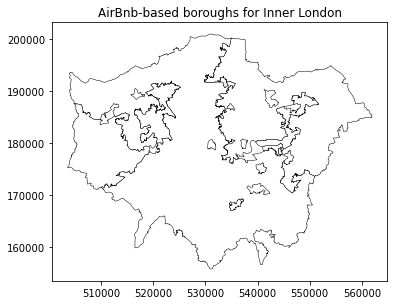

In [ ]:
# Setup figure and ax
f, ax = plt.subplots(1,figsize=(6, 6))
# Plot boundary lines
lon_boroughs.plot(ax=ax, 
                  linewidth=0.5,
                  facecolor='white', 
                  edgecolor='k'
                 )
# Remove axis
# ax.set_axis_off()
# Add title
plt.title('AirBnb-based boroughs for Inner London')

In [ ]:
boroughs = gpd.read_file(path/'statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp')

Text(0.5, 1.0, 'Administrative boroughs for Inner London')

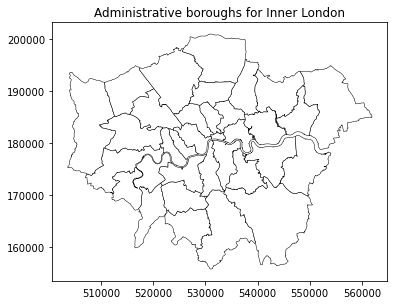

In [ ]:
# Setup figure and ax
f, ax = plt.subplots(1, figsize=(6, 6))
# Plot boundary lines
boroughs.plot(ax=ax, 
              linewidth=0.5,
              edgecolor='k', 
              facecolor='white'
             )
# Remove axis
# ax.set_axis_off()
# Add title
plt.title('Administrative boroughs for Inner London')



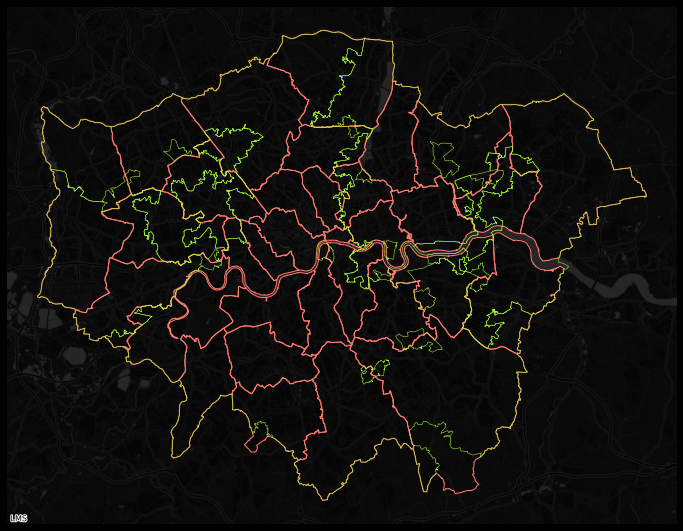

In [ ]:
# Set up figure
f, ax = plt.subplots(1, figsize=(12, 12))
f.set_facecolor("k")

#Add boroughs
boroughs.to_crs(crs)\
        .plot(ax=ax,
              facecolor="none",
              edgecolor="xkcd:salmon",
              linewidth=1
             )

# Add regionalisation geography
lon_boroughs.to_crs(crs).plot(ax=ax,
                  facecolor="none",
                  edgecolor="xkcd:lime",
                  linewidth=0.5
                 )

# Add basemap
ctx.add_basemap(ax,
               crs=crs,
               source=ctx.providers.CartoDB.DarkMatterNoLabels,attribution= 'LMS'
              )

# Remove axis
ax.set_axis_off()
# Display clean
plt.show()